In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
%matplotlib inline 

In [2]:
from yaml import load as yaml_load
import findspark
findspark.init()
import pyspark
from pyspark.sql.types import DoubleType
from pyspark.sql import SparkSession
import pyspark.sql.functions as func
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler, VectorIndexer, StandardScaler
from pyspark.sql.functions import *
from pyspark.sql.types import DoubleType
spark = SparkSession.builder.master("local").appName("Data cleaning").getOrCreate()

In [3]:
import os
import sys
sys.path.append('../')

In [4]:
sc = spark.sparkContext

In [5]:
import json

In [6]:
from src.data.make_dataset import LoadDataframe

In [8]:
def _load_config_file(config_file):
    """
    Load configuration file
    :param config_file: is the configuration file
    :return: configuration
    :rtype: dict
    """
    with open(config_file) as yml_config:
        return yaml_load(yml_config)

def _build_configuration(config_file):
    """
    Build the operation configuration dict
    :param config_file: is the path to the yaml config_file
    :type: string
    :return: config: global configuration
    :rtype dict
    """
    # yaml config
    config = _load_config_file(config_file)
    return config
def visualisation_prediction(y_test, y_pred):
    import matplotlib
    import matplotlib.pyplot as plt
    matplotlib.rc('xtick', labelsize=30) 
    matplotlib.rc('ytick', labelsize=30) 
    fig, ax = plt.subplots(figsize=(50, 40))
    plt.style.use('ggplot')
    plt.plot(y_pred, y_test, 'ro')
    plt.xlabel('Predicted Crime', fontsize = 30)
    plt.ylabel('Actual Crime', fontsize = 30)
    plt.title('Predicted Y (Crimes) to the Actual Y (Crimes)', fontsize = 30)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
config_file = "/home/ml/Documents/crimes_chigaco/config/config.yml"
config = _build_configuration(config_file)

In [9]:
%%time
obj_df_loaded = LoadDataframe(config, '2013', '2014')

CPU times: user 896 µs, sys: 159 µs, total: 1.06 ms
Wall time: 8 ms


In [11]:
%%time
df_nb_crimes = obj_df_loaded.df_nb_crimes()

/usr/lib/spark/spark-2.4.0-bin-hadoop2.7/python/pyspark/sql/dataframe.py:1793: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


CPU times: user 58.7 ms, sys: 15.6 ms, total: 74.4 ms
Wall time: 2min 30s


In [12]:
%%time
df_nb_crimes.limit(1000).toPandas().sample(5)

CPU times: user 44.3 ms, sys: 11.2 ms, total: 55.4 ms
Wall time: 1min 16s


,community_area_number,month,year,primary_type,nb_crimes,community_area_name,pct_housing_crowded,pct_households_below_poverty,pct_age16_unemployed,pct_age25_no_highschool,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
511,19,10,2013,WEAPONS VIOLATION,2,Belmont Cragin,10.8,18.7,14.6,37.3,...,0,0,0,0,0,0,0,1,0,0
884,68,5,2013,ARSON,3,Englewood,3.8,46.6,28,28.5,...,0,0,1,0,0,0,0,0,0,0
13,22,5,2013,LIQUOR LAW VIOLATION,1,Logan Square,3.2,16.8,8.2,14.8,...,0,0,1,0,0,0,0,0,0,0
515,25,12,2013,CRIM SEXUAL ASSAULT,6,Austin,6.3,28.6,22.6,24.4,...,0,0,0,0,0,0,0,0,0,1
387,70,2,2013,NARCOTICS,12,Ashburn,4,10.4,11.7,17.7,...,0,0,0,0,0,0,0,0,0,0


In [16]:
columns_feature = ['community_area_number',
 'month',
 'year',
 'primary_type',
 'nb_crimes',
 'community_area_name',
 'pct_housing_crowded',
 'pct_households_below_poverty',
 'pct_age16_unemployed',
 'pct_age25_no_highschool',
 'pct_not_working_age',
 'per_capita_income',
 'hardship_index']

In [17]:
list_columns = df_nb_crimes.columns

In [18]:
data = df_nb_crimes.drop(*['community_area_number', 'month', 'year', 'primary_type', 'community_area_name'])

In [19]:
data.limit(5).toPandas()

,nb_crimes,pct_housing_crowded,pct_households_below_poverty,pct_age16_unemployed,pct_age25_no_highschool,pct_not_working_age,per_capita_income,hardship_index,primary_type_ARSON,primary_type_CRIM SEXUAL ASSAULT,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,28,7.7,23.6,8.7,18.2,27.5,23939,39,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,7.7,23.6,8.7,18.2,27.5,23939,39,0,0,...,0,0,0,0,0,1,0,0,0,0
2,13,7.7,23.6,8.7,18.2,27.5,23939,39,0,0,...,0,0,0,0,0,0,0,1,0,0
3,8,2,5.4,9,11.5,39.5,32875,21,0,0,...,1,0,0,0,0,0,0,0,0,0
4,4,2.7,8.6,12.4,13.4,35.5,27751,25,0,0,...,0,0,0,0,0,1,0,0,0,0


In [20]:
data.printSchema()

root
 |-- nb_crimes: long (nullable = false)
 |-- pct_housing_crowded: string (nullable = true)
 |-- pct_households_below_poverty: string (nullable = true)
 |-- pct_age16_unemployed: string (nullable = true)
 |-- pct_age25_no_highschool: string (nullable = true)
 |-- pct_not_working_age: string (nullable = true)
 |-- per_capita_income: string (nullable = true)
 |-- hardship_index: string (nullable = true)
 |-- primary_type_ARSON: long (nullable = true)
 |-- primary_type_CRIM SEXUAL ASSAULT: long (nullable = true)
 |-- primary_type_CRIMINAL DAMAGE: long (nullable = true)
 |-- primary_type_CRIMINAL TRESPASS: long (nullable = true)
 |-- primary_type_DECEPTIVE PRACTICE: long (nullable = true)
 |-- primary_type_GAMBLING: long (nullable = true)
 |-- primary_type_HOMICIDE: long (nullable = true)
 |-- primary_type_INTERFERENCE WITH PUBLIC OFFICER: long (nullable = true)
 |-- primary_type_INTIMIDATION: long (nullable = true)
 |-- primary_type_KIDNAPPING: long (nullable = true)
 |-- primary_type

In [21]:
features_socio = ['pct_housing_crowded',
 'pct_households_below_poverty','pct_age16_unemployed',
 'pct_age25_no_highschool',
 'pct_not_working_age',
 'per_capita_income',
 'hardship_index']

In [22]:
data = data.withColumnRenamed('nb_crimes', 'label')

In [24]:
for f in features_socio:
    data = data.withColumn(f, data[f].cast(DoubleType()))

In [25]:
features = data.columns

In [26]:
features.remove('label')

In [30]:
vectorAssembler = VectorAssembler(inputCols=features, outputCol="unscaled_features")
standardScaler = StandardScaler(inputCol="unscaled_features", outputCol="features")

In [33]:
%%time
gbt = GBTRegressor(featuresCol="features", maxIter=100, maxDepth= 8)

CPU times: user 1.3 ms, sys: 141 µs, total: 1.45 ms
Wall time: 14.6 ms


In [34]:
stages = [vectorAssembler, standardScaler, gbt]

In [35]:
pipeline = Pipeline(stages=stages)

In [36]:
%%time
(training, test) = data.randomSplit([.7, .3])

CPU times: user 2.25 ms, sys: 258 µs, total: 2.51 ms
Wall time: 150 ms


In [37]:
training.limit(5).toPandas()

,label,pct_housing_crowded,pct_households_below_poverty,pct_age16_unemployed,pct_age25_no_highschool,pct_not_working_age,per_capita_income,hardship_index,primary_type_ARSON,primary_type_CRIM SEXUAL ASSAULT,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1,1.1,3.3,6.5,7.4,35.3,40959.0,8.0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,1.5,14.7,5.7,3.1,13.5,65526.0,3.0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,3.3,27.8,24.0,14.5,40.3,18881.0,60.0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,3.8,24.0,8.9,11.8,22.2,35787.0,20.0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,4.1,18.2,9.2,9.7,23.8,33385.0,19.0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [38]:
%%time
model = pipeline.fit(training)

CPU times: user 589 ms, sys: 102 ms, total: 691 ms
Wall time: 1h 34min 55s


In [39]:
prediction = model.transform(test)

In [40]:
prediction.limit(10).toPandas()

,label,pct_housing_crowded,pct_households_below_poverty,pct_age16_unemployed,pct_age25_no_highschool,pct_not_working_age,per_capita_income,hardship_index,primary_type_ARSON,primary_type_CRIM SEXUAL ASSAULT,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,unscaled_features,features,prediction
0,1,1.1,7.5,6.8,4.9,40.5,44164.0,11.0,0,0,...,0,0,0,0,1,0,0,"(1.1, 7.5, 6.8, 4.9, 40.5, 44164.0, 11.0, 0.0,...","(0.2860842651652907, 0.6808612610352378, 0.918...",-0.244726
1,1,2.6,8.8,11.3,19.3,38.1,26353.0,32.0,1,0,...,0,0,0,0,0,0,1,"(2.6, 8.8, 11.3, 19.3, 38.1, 26353.0, 32.0, 1....","(0.6761991722088688, 0.7988772129480125, 1.525...",0.934025
2,1,2.8,31.1,20.0,14.0,35.7,19398.0,55.0,0,0,...,0,0,0,0,0,1,0,"(2.8, 31.1, 20.0, 14.0, 35.7, 19398.0, 55.0, 0...","(0.7282144931480125, 2.823304695759453, 2.7005...",4.728442
3,1,3.2,16.8,8.2,14.8,26.2,31908.0,23.0,0,0,...,0,0,0,0,0,0,0,"(3.2, 16.8, 8.2, 14.8, 26.2, 31908.0, 23.0, 0....","(0.8322451350263, 1.5251292247189328, 1.107223...",2.778553
4,1,7.7,23.6,8.7,18.2,27.5,23939.0,39.0,0,0,...,0,0,1,0,0,0,0,"(7.7, 23.6, 8.7, 18.2, 27.5, 23939.0, 39.0, 0....","(2.0025898561570346, 2.1424434347242154, 1.174...",1.774885
5,1,14.8,33.9,17.3,35.4,38.0,13781.0,85.0,0,0,...,0,0,0,0,1,0,0,"(14.8, 33.9, 17.3, 35.4, 38.0, 13781.0, 85.0, ...","(3.849133749496638, 3.077492899879275, 2.33597...",1.322269
6,2,1.5,18.4,8.4,4.3,26.2,39056.0,14.0,0,0,...,0,0,0,0,1,0,0,"(1.5, 18.4, 8.4, 4.3, 26.2, 39056.0, 14.0, 0.0...","(0.3901149070435781, 1.6703796270731166, 1.134...",0.557333
7,2,2.8,31.1,20.0,14.0,35.7,19398.0,55.0,0,0,...,0,0,0,0,0,0,0,"(2.8, 31.1, 20.0, 14.0, 35.7, 19398.0, 55.0, 0...","(0.7282144931480125, 2.823304695759453, 2.7005...",2.885730
8,2,3.6,29.6,23.0,16.5,41.0,17285.0,66.0,0,0,...,0,0,0,0,0,0,1,"(3.6, 29.6, 23.0, 16.5, 41.0, 17285.0, 66.0, 0...","(0.9362757769045875, 2.6871324435524055, 3.105...",2.353246
9,2,7.2,18.7,13.4,32.9,35.6,16954.0,61.0,0,0,...,1,0,0,0,0,0,0,"(7.2, 18.7, 13.4, 32.9, 35.6, 16954.0, 61.0, 0...","(1.872551553809175, 1.6976140775145263, 1.8093...",1.370817


In [41]:
df_result = prediction.select(*['label','prediction']).toPandas()

In [42]:
df_result.sample(5)

,label,prediction
2135,44,54.690902
2355,19,12.602899
645,10,19.543751
1640,5,5.033478
2294,1,4.531867


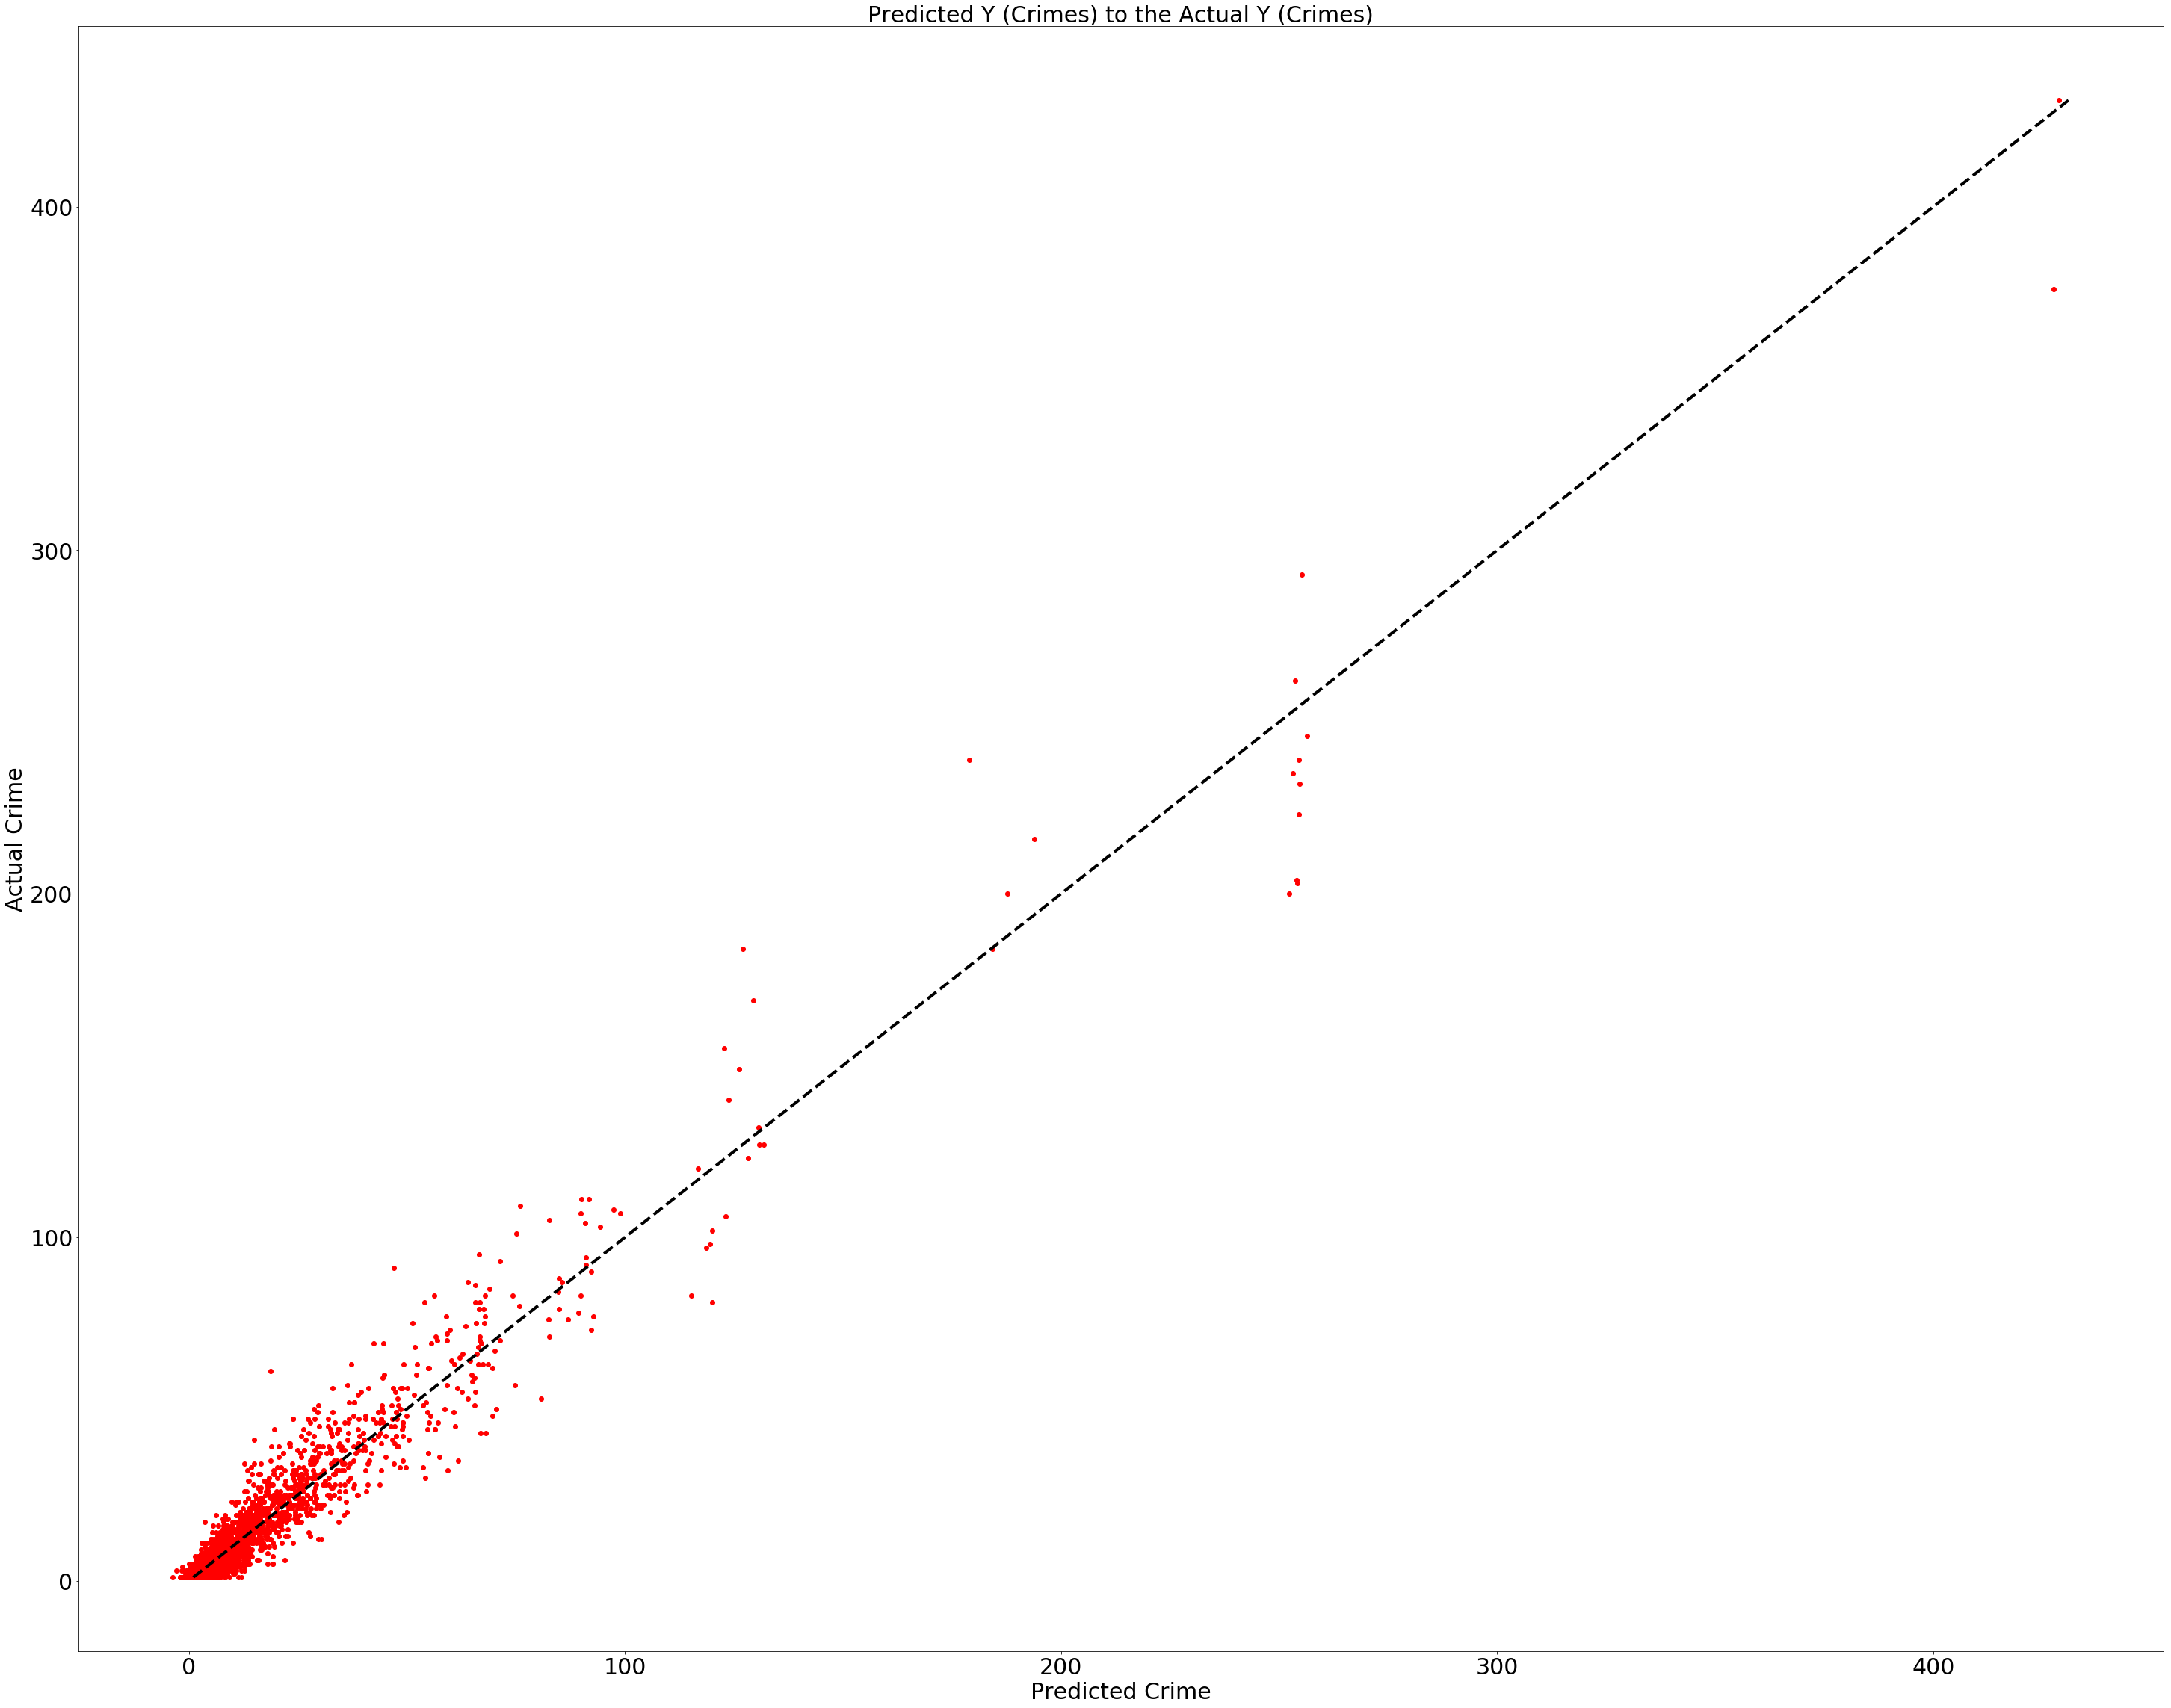

In [45]:
visualisation_prediction(df_result['label'], df_result['prediction'])

In [46]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(prediction)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 5.84365


In [47]:
from sklearn.metrics import r2_score

In [48]:
r2_score(df_result['label'], df_result['prediction'])  

0.9439219231670819

In [59]:
gbtr_path = "/home/ml/Documents/crimes_chigaco_spark/models/"+ "gbtr_2013"

In [60]:
gbt.save(gbtr_path)